# Kernel Ridge Regression

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ChemAI-Lab/AI4Chem/blob/main/website/modules/02-kernel_ridge_regression.ipynb)

**References:**
1. **Chapters 6**: [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/wp-content/uploads/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf), C. M. Bishop.
2. **Chapter 2**:  [Gaussian Processes for Machine LearningOpen Access](https://direct.mit.edu/books/oa-monograph-pdf/2514321/book_9780262256834.pdf), C. E. Rasmussen, C. K. I. Williams
3. **Chapter 4**: [Machine Learning in Quantum Sciences](https://arxiv.org/pdf/2204.04198)
4. [**The Kernel Cookbook**](https://www.cs.toronto.edu/~duvenaud/cookbook/)

# Potential Energy Surface 

The following data is based on a Polynomial expansion to predict the electronic energy of methane for different geometries. <br>
We will follow the work presented in the paper, [paper link](https://pubs.acs.org/doi/full/10.1021/acs.jctc.9b00043)<br>
"*Using Gradients in Permutationally Invariant Polynomial Potential Fitting: A Demonstration for CH4 Using as Few as 100 Configurations*".

The main idea is to expand the inter-atomic distance of the 5 atoms in terms on a polynomial expansion,
$$
y = \sum^{np}_{i} w_i \phi_i(\mathbf{r})
$$
where $w_i$ are the weights, $\phi_i$ are the Permutationally Invariant Polynomial expansion, and $\mathbf{r}$ are the inter-atomic distances. 

In the dataset provided, the values of the vector 
$$
\mathbf{\phi}(\mathbf{r})^\top = [\phi_0(\mathbf{r}),\cdots,\phi_{np}(\mathbf{r})],
$$ 
are in each column of a raw, with the respective energy in the last column. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# load data using pandas
data_file = 'https://raw.githubusercontent.com/ChemAI-Lab/Math4Chem/main/website/Assignments/CH4_data.csv'
data = pd.read_csv(data_file)
data.head()

,Unnamed: 0,phi_0,phi_1,phi_2,phi_3,phi_4,phi_5,phi_6,phi_7,phi_8,...,phi_21,phi_22,phi_23,phi_24,phi_25,phi_26,phi_27,phi_28,phi_29,energy
0,0,1.0,0.206794,0.047658,0.016033,0.004927,0.000189,0.004928,0.000757,0.010698,...,0.001659,0.000255,0.000255,0.000039,0.000003,0.000039,0.000012,0.000554,0.000003,-40.483220
1,1,1.0,0.204853,0.047194,0.015728,0.004834,0.000186,0.004834,0.000740,0.010509,...,0.001613,0.000248,0.000248,0.000038,0.000003,0.000038,0.000012,0.000540,0.000003,-40.481880
2,2,1.0,0.202104,0.046530,0.015310,0.004705,0.000180,0.004699,0.000718,0.010226,...,0.001549,0.000238,0.000238,0.000037,0.000003,0.000037,0.000011,0.000518,0.000003,-40.480698
3,3,1.0,0.199966,0.046054,0.014993,0.004608,0.000176,0.004601,0.000703,0.010000,...,0.001499,0.000231,0.000230,0.000036,0.000003,0.000036,0.000011,0.000500,0.000003,-40.480026
4,4,1.0,0.199642,0.046051,0.014946,0.004597,0.000175,0.004596,0.000703,0.009966,...,0.001492,0.000229,0.000229,0.000036,0.000003,0.000036,0.000011,0.000498,0.000003,-40.479866


The dataset contains 9000 points.
The point with the lowest energy is 130 with a value of -40.48363 Ha.
The range of energies in the dataset is 0.06712599999999469 Ha.


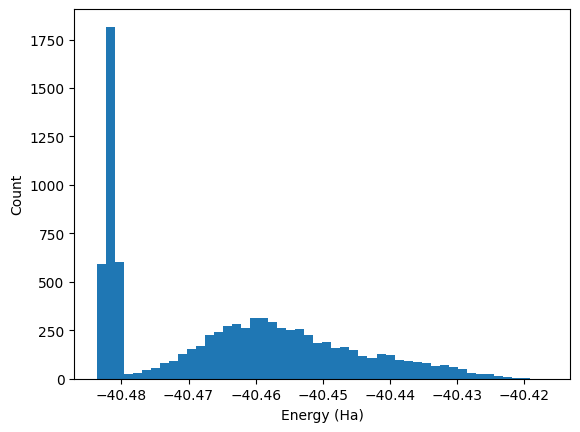

In [5]:

# 1. How many points does the dataset contains?
n = data.shape[0]
print('The dataset contains {} points.'.format(n))

# 2. What is the point with the lowest energy and what is its value?
lowest_energy = data['energy'].min()
lowest_energy_point = data[data['energy'] == lowest_energy]
print('The point with the lowest energy is {} with a value of {} Ha.'.format(
    lowest_energy_point.iloc[0, 0], lowest_energy))

# 3. What is the range of energies in the dataset? The energy is reported in Hartrees
energy_range = data['energy'].max() - data['energy'].min()
print('The range of energies in the dataset is {} Ha.'.format(energy_range))

# 4. Do a histogram of the energy.
plt.hist(data['energy'], bins=50)
plt.xlabel('Energy (Ha)')
plt.ylabel('Count')
plt.show()

In [6]:
# Load PIPs representation per molecule
y_all = data['energy'].to_numpy()
print('Total energy points:', y_all.shape)
X_all = data.drop(['energy', 'Unnamed: 0'], axis=1).to_numpy()
print("Total Geometries:", X_all.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Total energy points: (9000,)
Total Geometries: (9000, 30)
Training set size: (6300, 30)
Test set size: (2700, 30)


# Kernel Ridge Regression



Kernel ridge regression (KRR) combines ridge regression with the kernel trick, enabling linear regression to be performed in a (possibly high-dimensional) feature space without explicitly constructing the feature map. The model is trained by minimizing the squared error with an  L2 regularization term, controlled by the regularization parameter $\lambda$; in scikit-learn this is named $\alpha$.

When a linear kernel is used, KRR is mathematically equivalent to standard ridge regression. Nevertheless, framing the problem in the kernel setting is useful, as it allows us to apply the same training and validation machinery used for more general kernels. In particular, the regularization strength $\lambda$ can be selected via cross-validation.

Below, we use cross-validation to choose the optimal value of $\lambda$ for linear KRR and then evaluate the resulting model on a held-out test set.

In [7]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

# Linear kernel ridge regression with cross-validated regularization strength
param_grid = {"alpha": np.logspace(-8, 2, 11)}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
krr = KernelRidge(kernel="linear")
grid = GridSearchCV(krr, param_grid=param_grid, cv=cv, scoring="neg_mean_squared_error")
grid.fit(X_train, y_train)

print("Best alpha: {}".format(grid.best_params_["alpha"]))
best_krr = grid.best_estimator_
y_pred = best_krr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE: {:.6f}".format(rmse))


Best alpha: 1e-08
Test RMSE: 0.002435


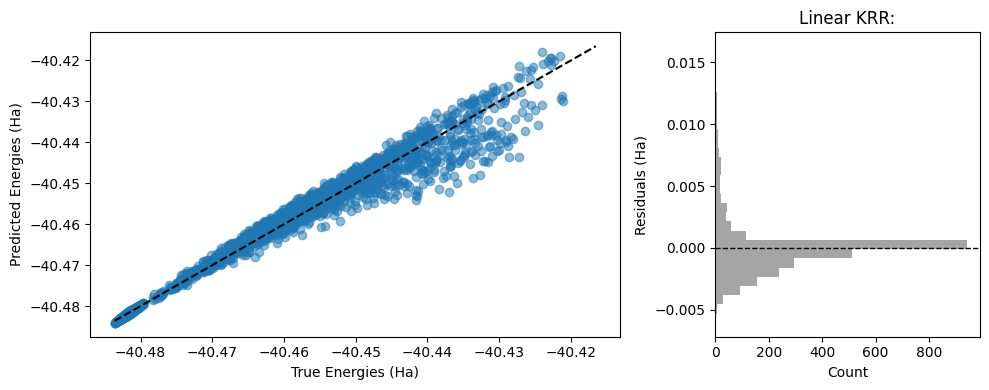

In [8]:
fig, (ax_scatter, ax_hist) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})

ax_scatter.scatter(y_test, y_pred, alpha=0.5)
ax_scatter.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'k--')
ax_scatter.set_xlabel('True Energies (Ha)')
ax_scatter.set_ylabel('Predicted Energies (Ha)')

residuals = y_test - y_pred
ax_hist.hist(residuals, bins=30, orientation='horizontal', color='tab:gray', alpha=0.7)
ax_hist.axhline(0.0, color='k', linestyle='--', linewidth=1)
ax_hist.set_xlabel('Count')
ax_hist.set_ylabel('Residuals (Ha)')

plt.title("Linear KRR:")
plt.tight_layout()


In [9]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# RBF kernel ridge regression with cross-validated alpha and gamma
param_grid = {
    "alpha": np.logspace(-8, 2, 11),
    "gamma": np.logspace(-2, 5, 13),
}

cv = KFold(n_splits=2, shuffle=True, random_state=42)

krr = KernelRidge(kernel="rbf")

grid = GridSearchCV(
    krr,
    param_grid=param_grid,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_["alpha"])
print("Best gamma:", grid.best_params_["gamma"])

best_krr = grid.best_estimator_
y_pred = best_krr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE: {:.6f}".format(rmse))

Best alpha: 1e-08
Best gamma: 464.1588833612782
Test RMSE: 0.000735


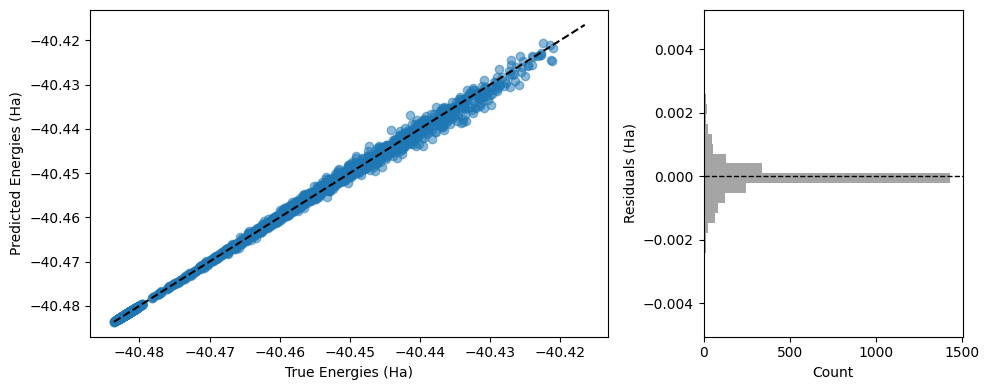

In [10]:
fig, (ax_scatter, ax_hist) = plt.subplots(
    1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})

ax_scatter.scatter(y_test, y_pred, alpha=0.5)
ax_scatter.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'k--')
ax_scatter.set_xlabel('True Energies (Ha)')
ax_scatter.set_ylabel('Predicted Energies (Ha)')

residuals = y_test - y_pred
ax_hist.hist(residuals, bins=30, orientation='horizontal',
             color='tab:gray', alpha=0.7)
ax_hist.axhline(0.0, color='k', linestyle='--', linewidth=1)
ax_hist.set_xlabel('Count')
ax_hist.set_ylabel('Residuals (Ha)')

plt.tight_layout()

## RBF Kernel: Effect of $\gamma$ (1D Example)

The RBF kernel parameter $\gamma$ controls the smoothness of the fitted function. Small $\gamma$ produces smoother functions, while large $\gamma$ can overfit the training data.
This is why $\gamma$ should be selected using cross-validation rather than by optimizing training error alone.


In [12]:
import ipywidgets as widgets
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Fixed 1D dataset for comparing different gamma values
rng = np.random.default_rng(42)
X_1d = rng.uniform(0.0, 1.0, 25)[:, None]
y_1d = np.sin(2 * np.pi * X_1d[:, 0]) + 0.2 * rng.normal(size=25)

X_train_1d, X_test_1d, y_train_1d, y_test_1d = train_test_split(
    X_1d, y_1d, test_size=0.3, random_state=42
)
x_grid = np.linspace(0.0, 1.0, 200)[:, None]

def plot_gamma(gamma=1.0):
    model = KernelRidge(kernel="rbf", alpha=1e-2, gamma=gamma)
    model.fit(X_train_1d, y_train_1d)

    y_grid = model.predict(x_grid)
    y_train_pred = model.predict(X_train_1d)
    y_test_pred = model.predict(X_test_1d)

    rmse_train = np.sqrt(mean_squared_error(y_train_1d, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test_1d, y_test_pred))

    plt.figure(figsize=(7, 4))
    plt.scatter(X_train_1d[:, 0], y_train_1d, c='tab:blue', label='train')
    plt.scatter(X_test_1d[:, 0], y_test_1d, c='tab:orange', label='test')
    plt.plot(x_grid[:, 0], y_grid, c='k', lw=2, label='KRR fit')
    plt.title(f'RBF KRR with gamma = {gamma:.3g} | RMSE train={rmse_train:.3f}, test={rmse_test:.3f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    # plt.show()

gamma_slider = widgets.FloatLogSlider(base=10, min=-2, max=6, step=0.1, value=1.0)
out = widgets.interactive_output(plot_gamma, {"gamma": gamma_slider})
display(gamma_slider, out)


FloatLogSlider(value=1.0, max=6.0, min=-2.0)

Output()